In [21]:
from vmad import Builder
from vmad import autooperator
from vmad import operator
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.misc import derivative
from nbodykit.lab import *
from nbodykit.cosmology.power.transfers import NoWiggleEisensteinHu
from vmad.core.stdlib.operators import mul, div, add, sub
from vmad.core.stdlib.operators import pow as power
from vmad.lib.unary import log
from vmad.lib.linalg import reshape

import matplotlib.pyplot as plt
%matplotlib notebook

# Einstein Ho no wiggles remixxxx

In [4]:
cosmo = cosmology.Planck15
cosmo = cosmo.match(sigma8=.8158)
cosmo = cosmo.clone(P_k_max=100)


\begin{equation}
\delta_H = 1.94\times 10^{-5}\Omega_{m,0}^{-.785-.05ln(\Omega_{m,0})}e^{\tilde{n}+1.97\tilde{n}^2}
\end{equation}

\begin{equation}
\dfrac{\partial\delta_H}{\partial \Omega_{m,0}} = 1.94\times 10^{-5}\left(-.785 + .05\ln(\Omega_{m,0})\right)\Omega_{m,0}^{-1.785 + .05\ln(\Omega_{m,0})}e^{\tilde{n}+1.97\tilde{n}^2}\dfrac{.05}{\Omega_{m,0}}
\end{equation}

In [6]:
@autooperator('omega0_m->delta_h')
def amplitude(omega0_m, n):
    factor_1 = mul(1.94e-5, power(omega0_m, sub(-.785, mul(.05, log(omega0_m)))))
    factor_2 = np.e**((n - 1) + 1.97 * (n - 1)**2)
    
    return dict(delta_h = mul(factor_1, factor_2))

\begin{equation}
    D_1(z) = (1+z)^{-1}\dfrac{5\Omega(z)}{2}\left[\Omega(z)^{4/7}-\Omega_\Lambda(z) +(1+\Omega(z)/2)(1+\Omega_\Lambda(z)/70)\right]^{-1}
\end{equation}

\begin{equation}
\begin{split}
\dfrac{\partial D_1(z)}{\partial \Omega} &= \dfrac{(1+z)^{-1}\dfrac{5}{2}}{\Omega (z)^{4/7} - \Omega_\Lambda (z)+(1+\Omega (z)/2)(1+\Omega_\Lambda (z)/70)}\left[1 - \dfrac{\Omega(z)\left( 4/7 \Omega (z)^{-3/7}+1/2+\Omega_\Lambda(z)/140\right)}{[\Omega (z)^{4/7} - \Omega_\Lambda (z)+(1+\Omega (z)/2)(1+\Omega_\Lambda (z)/70)}\right]\\
\dfrac{\partial D_1(z)}{\partial \Omega_\Lambda} &= -\dfrac{5\Omega (z)(-1+1/70+\Omega(z)/140)}{2(1+z)(\Omega (z)^{4/7} - \Omega_\Lambda (z)+(1+\Omega (z)/2)(1+\Omega_\Lambda (z)/70))^2}
\end{split}
\end{equation}


In [8]:
@autooperator('omega_z, omega_lambda->growth')
def grow(omega_z, omega_lambda, z):
    pre_fac = mul((1+z)**-1, div(mul(5, omega_z), 2))
    inside = power(
        add(sub(power(omega_z, 4/7), omega_lambda), 
            mul(add(1, div(omega_z,2)), 
                add(1, div(omega_lambda,70)))), 
        -1)
    return dict(growth=mul(pre_fac, inside))

\begin{equation}
\Omega(z) = \dfrac{\Omega_0 (1+z)^3}{\Omega_\Lambda+\Omega_0(1+z)^3}
\end{equation}

\begin{equation}
\dfrac{\partial \Omega(z)}{\partial \Omega_{0}} = \dfrac{(1+z)^3}{\Omega_\Lambda+\Omega_0(1+z)^3}\left[1 - \dfrac{\Omega_0 (1+z)^3}{\left(\Omega_\Lambda+\Omega_0(1+z)^3\right)}\right]
\end{equation}

In [10]:
@autooperator('omega0_m->omega_z')
def get_omega_z(omega0_m, z):
    omega0_l = sub(1, omega0_m)
    num      = mul(omega0_m, (1+z)**3)
    denom    = add(omega0_l, mul(omega0_m, (1+z)**3))
    return dict(omega_z = div(num, denom))

\begin{equation}
\Omega_\Lambda(z) = \dfrac{1-\Omega_0}{1-\Omega_0 + \Omega_0(1+z)^3}
\end{equation}

\begin{equation}
\dfrac{\partial \Omega_\Lambda(z)}{\partial \Omega_0} = \dfrac{-1}{1-\Omega_0 +\Omega_0(1+z)^3} - \dfrac{1-\Omega_0(-1+(1+z)^3)}{\left(1-\Omega_0+\Omega_0(1+z)^3\right)^2}
\end{equation}

In [12]:
@autooperator('omega0_m->omega_lambda')
def get_omega_lambda(omega0_m, z):
    omega0_l = sub(1, omega0_m)
    denom = add(omega0_l, mul(omega0_m, (1+z)**3))
    return dict(omega_lambda = div(omega0_l, denom))

In [14]:
@autooperator('Omega0_m->Pk')
def get_pklin(Omega0_m, Omega0_b, h, Tcmb0, C, H0, n, z, k):

    Obh2 = Omega0_b * h**2
    Omh2 = mul(Omega0_m, power(h, 2))
    f_baryon = div(Omega0_b, Omega0_m)
    
    theta_cmb = Tcmb0 / 2.7

    k_eq = mul(mul(0.0746, Omh2), power(theta_cmb, -2))  # units of 1/Mpc

    sound_horizon = div(mul(h * 44.5, log(div(9.83, Omh2))),
                        np.sqrt(1 + 10 * Obh2**0.75))  # in Mpc/h


    alpha_gamma = sub(1, add(mul(mul(0.328, log(431*Omh2)), f_baryon), \
                        mul(mul(0.38, log(22.3*Omh2)), power(f_baryon, 2))))
    
    k = k * h  # in 1/Mpc now
    ks = mul(k, div(sound_horizon, h))
    q = div(k, mul(13.41, k_eq))

    gamma_eff = mul(
        Omh2, (alpha_gamma +
               div(sub(1, alpha_gamma), add(1, power(mul(0.43, ks), 4)))))
    
    q_eff = mul(q, div(Omh2, gamma_eff))

    L0 = log(add(mul(2, np.e), mul(1.8, q_eff)))
    C0 = add(14.2, div(731.0, add(1, mul(62.5, q_eff))))

    T = div(L0, add(L0, mul(C0, power(q_eff, 2))))

    ### ADD GROWTH###
    omega_zs = get_omega_z(Omega0_m, z)
    omega_lambdas = get_omega_lambda(Omega0_m, z)
    growth_z = grow(omega_zs, omega_lambdas, z)

    ###ADD AMPLITUDE###
    delta_h = amplitude(Omega0_m, n)

    ###ADD FACTOR###
    factor = 2 * np.pi**2 / (k)**3 * (C * k / H0)**(3 + n)

    Pk = div(
        mul(mul(mul(power(delta_h, 2), power(T, 2)), power(growth_z, 2)),
            factor), h**3)

    return dict(Pk=Pk)

In [17]:
Omega0_b = cosmo.Omega0_b
h = cosmo.h
Tcmb0 = cosmo.Tcmb0
C = cosmo.C
H0 = cosmo.H0
n = cosmo.n_s
k = np.linspace(.005, 1.5, 1e5)
z = 1



p, tape= get_pklin.build(Omega0_b = Omega0_b, h=h, Tcmb0=Tcmb0, C=C, \
                                           H0=H0, n=n, z=z, k=k).compute(init = dict(Omega0_m=cosmo.Omega0_m),\
                                                                         vout='Pk', return_tape=True)

In [18]:
Plin = cosmology.LinearPower(cosmo, z, transfer='NoWiggleEisensteinHu')
cos_pow = Plin.__call__(k)
error = (p - cos_pow)/cos_pow

<IPython.core.display.Javascript object>


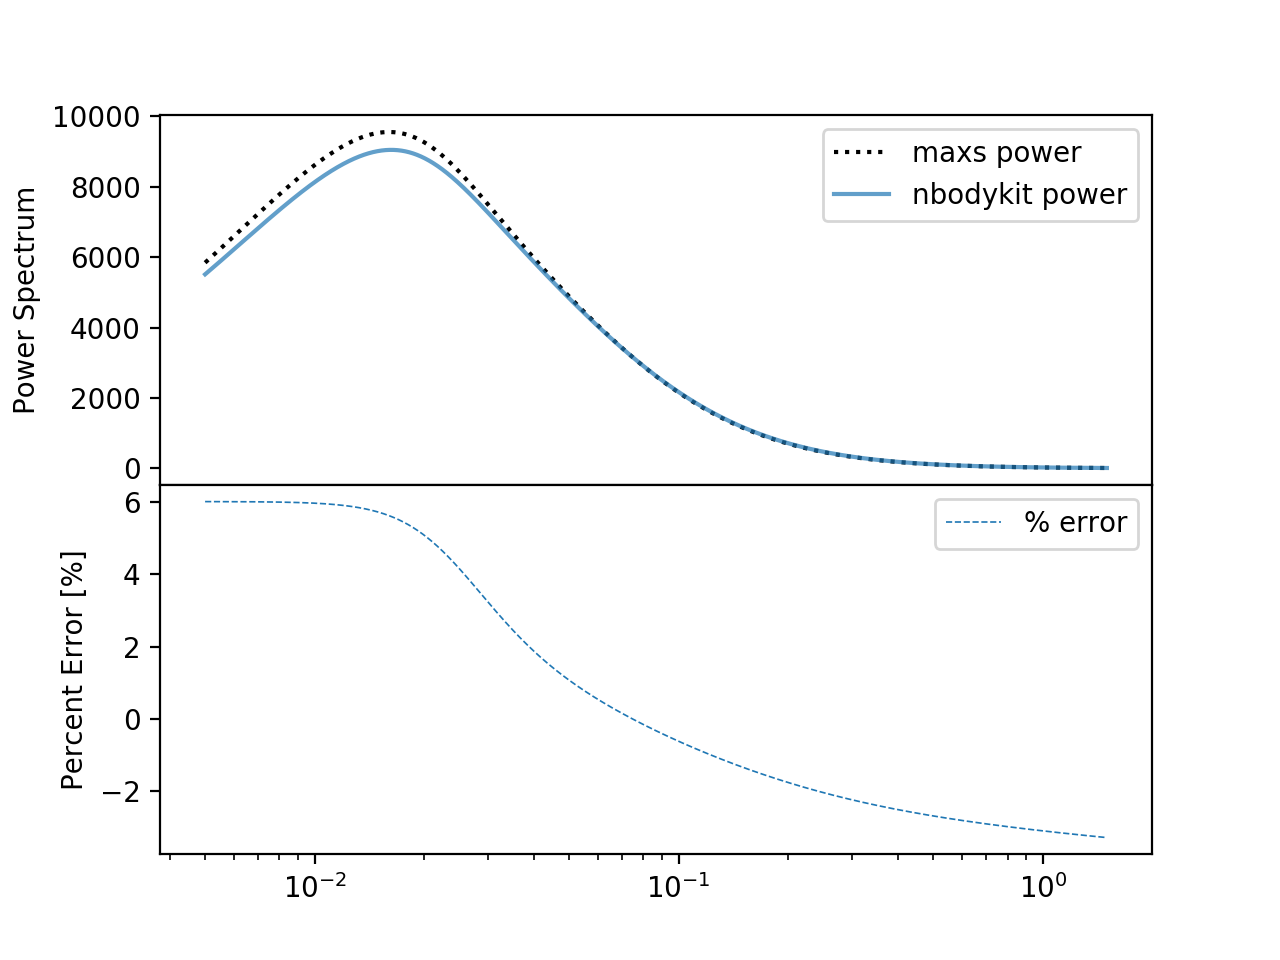

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'hspace': 0})
ax1.semilogx(k, p, ':k', label='maxs power')
ax1.semilogx(k, cos_pow, label='nbodykit power', alpha=.7)
ax1.set_xlabel('k')
ax1.set_ylabel('Power Spectrum')
ax1.legend()
ax2.semilogx(k, 100*error, '--', label='% error', lw=.6)
ax2.set_ylabel('Percent Error [%]')
ax2.legend()

In [23]:
vjp = tape.get_vjp()
_Omega0_m = vjp.compute(init=dict(_Pk=1), vout='_Omega0_m')

<IPython.core.display.Javascript object>


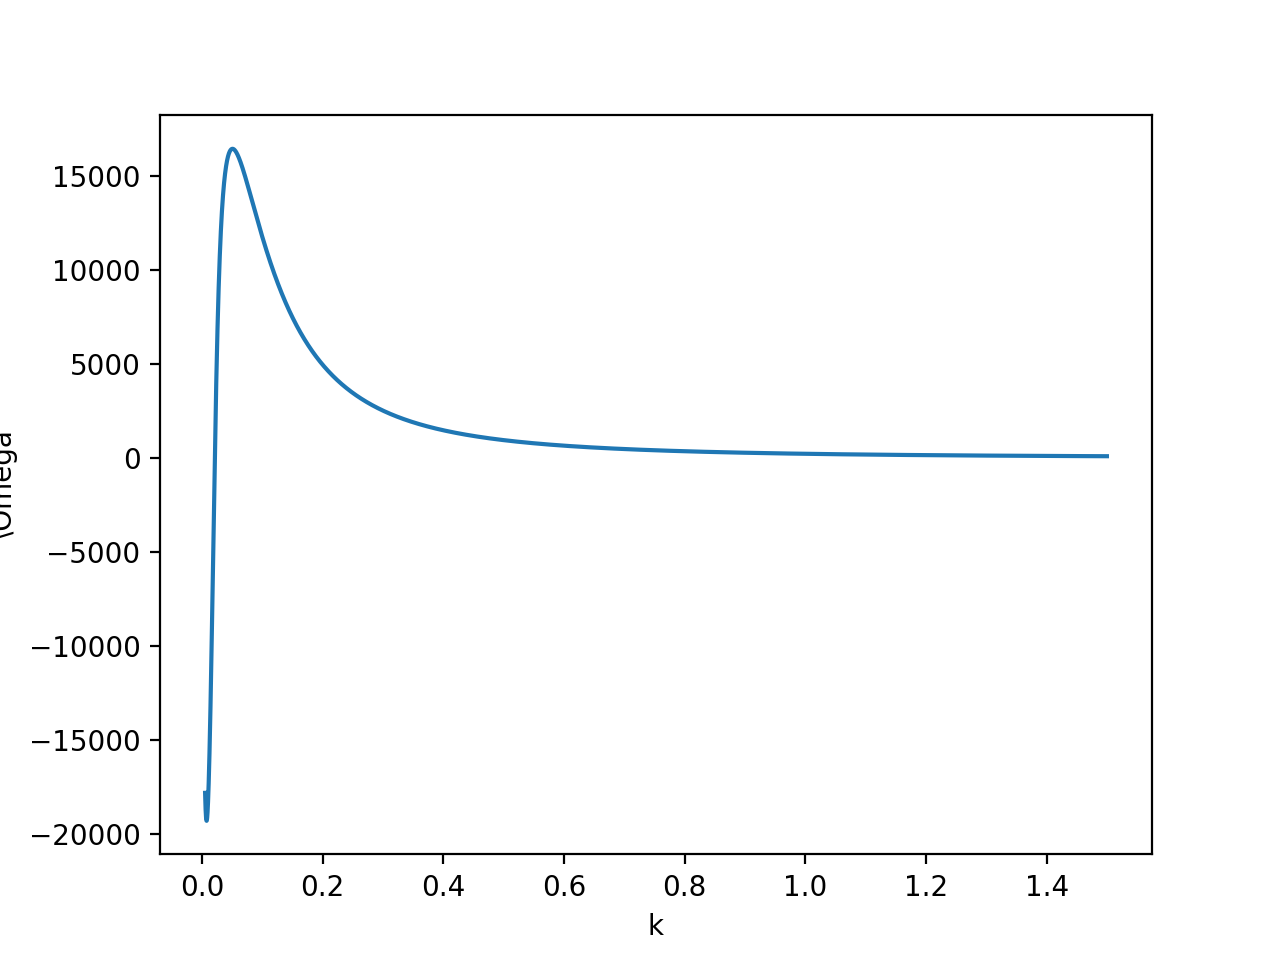

Text(0, 0.5, '\\Omega')

In [25]:
plt.figure()
plt.plot(k, _Omega0_m)
plt.xlabel('k')
plt.ylabel('\Omega')

# Max and Min k

In [28]:
phi = np.array([np.arctan(256*cosmo.h/cosmo.comoving_distance(10)), 
                np.arctan(cosmo.h/(cosmo.comoving_distance(10)))])
l = 1/phi
k = l/cosmo.comoving_distance(10)

In [29]:
k

array([0.00576789, 1.47623266])